In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import cv2  
import os

2025-08-06 02:59:25.740451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754449166.001800      78 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754449166.100544      78 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
DATASET_PATH = r"/kaggle/input/rice-disease-detection/Rice Leaf Disease Images"


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20 

In [4]:
print("Loading dataset from directory...")

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)
print(f"Found {n_classes} classes: {class_names}")



Loading dataset from directory...
Found 7420 files belonging to 5 classes.


I0000 00:00:1754449183.788040      78 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754449183.788767      78 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5 classes: ['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']


In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Training batches: {len(train_ds)}, Validation batches: {len(val_ds)}, Test batches: {len(test_ds)}")


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Apply augmentation only to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=AUTOTUNE)


Training batches: 185, Validation batches: 23, Test batches: 24


In [6]:
def create_model(input_shape, num_classes):
    """Creates the CNN model."""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', name="last_conv_layer"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),

        layers.Dense(num_classes, activation='softmax'),
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = create_model(input_shape, n_classes)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
print("\nStarting model training...")
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, 
    epochs=EPOCHS,
)
print("Model training finished.")


Starting model training...
Epoch 1/20


I0000 00:00:1754449203.496775     133 service.cc:148] XLA service 0x7e93e8104f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754449203.497724     133 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754449203.497744     133 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754449203.895735     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/185 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.2109 - loss: 1.6083    

I0000 00:00:1754449209.189958     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 90s 367ms/step - accuracy: 0.4968 - loss: 1.1341 - val_accuracy: 0.7215 - val_loss: 0.7158
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 299ms/step - accuracy: 0.7355 - loss: 0.6723 - val_accuracy: 0.7935 - val_loss: 0.5518
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 299ms/step - accuracy: 0.7761 - loss: 0.5500 - val_accuracy: 0.7989 - val_loss: 0.5079
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.8267 - loss: 0.4284 - val_accuracy: 0.8329 - val_loss: 0.4361
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 298ms/step - accuracy: 0.8635 - loss: 0.3341 - val_accuracy: 0.8832 - val_loss: 0.2705
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 296ms/step - accuracy: 0.8922 - loss: 0.2654 - val_accuracy: 0.8954 - val_loss: 0.2567
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 294ms/step - accuracy: 0.8257 - loss: 0.5029 - val_accuracy: 0.8967 - val_loss: 0.2775
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - accuracy: 0.9147 - loss: 0.2284 - val


Evaluating model on the test set...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9956 - loss: 0.0174
Test Loss: 0.02350885421037674
Test Accuracy: 0.9921466112136841


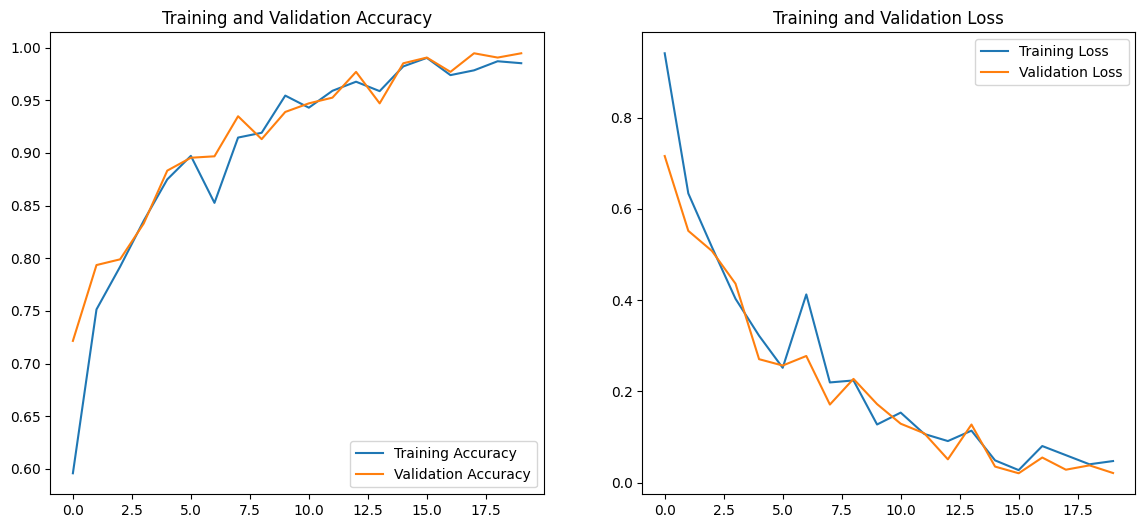

In [11]:

print("\nEvaluating model on the test set...")
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

def plot_training_results(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epoch_range = range(epochs)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, acc, label='Training Accuracy')
    plt.plot(epoch_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, loss, label='Training Loss')
    plt.plot(epoch_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_results(history, EPOCHS)

In [15]:
def plot_metrics(history, f1_scores):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss'] # This is your validation cross-entropy
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(18, 6))

    # Plot Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Cross-Entropy Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Cross-Entropy')
    plt.plot(epochs_range, val_loss, label='Validation Cross-Entropy')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Cross-Entropy')
    
    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, f1_scores, label='Validation F1 Score (Macro)', color='g')
    plt.legend(loc='lower right')
    plt.title('Validation F1 Score per Epoch')

    plt.show()


Setting up detailed explanations for model predictions...
Generating a clear, spacious report with embedded explanations...


/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 128064 (\N{EYES}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_78/1695519384.py:161: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from curren

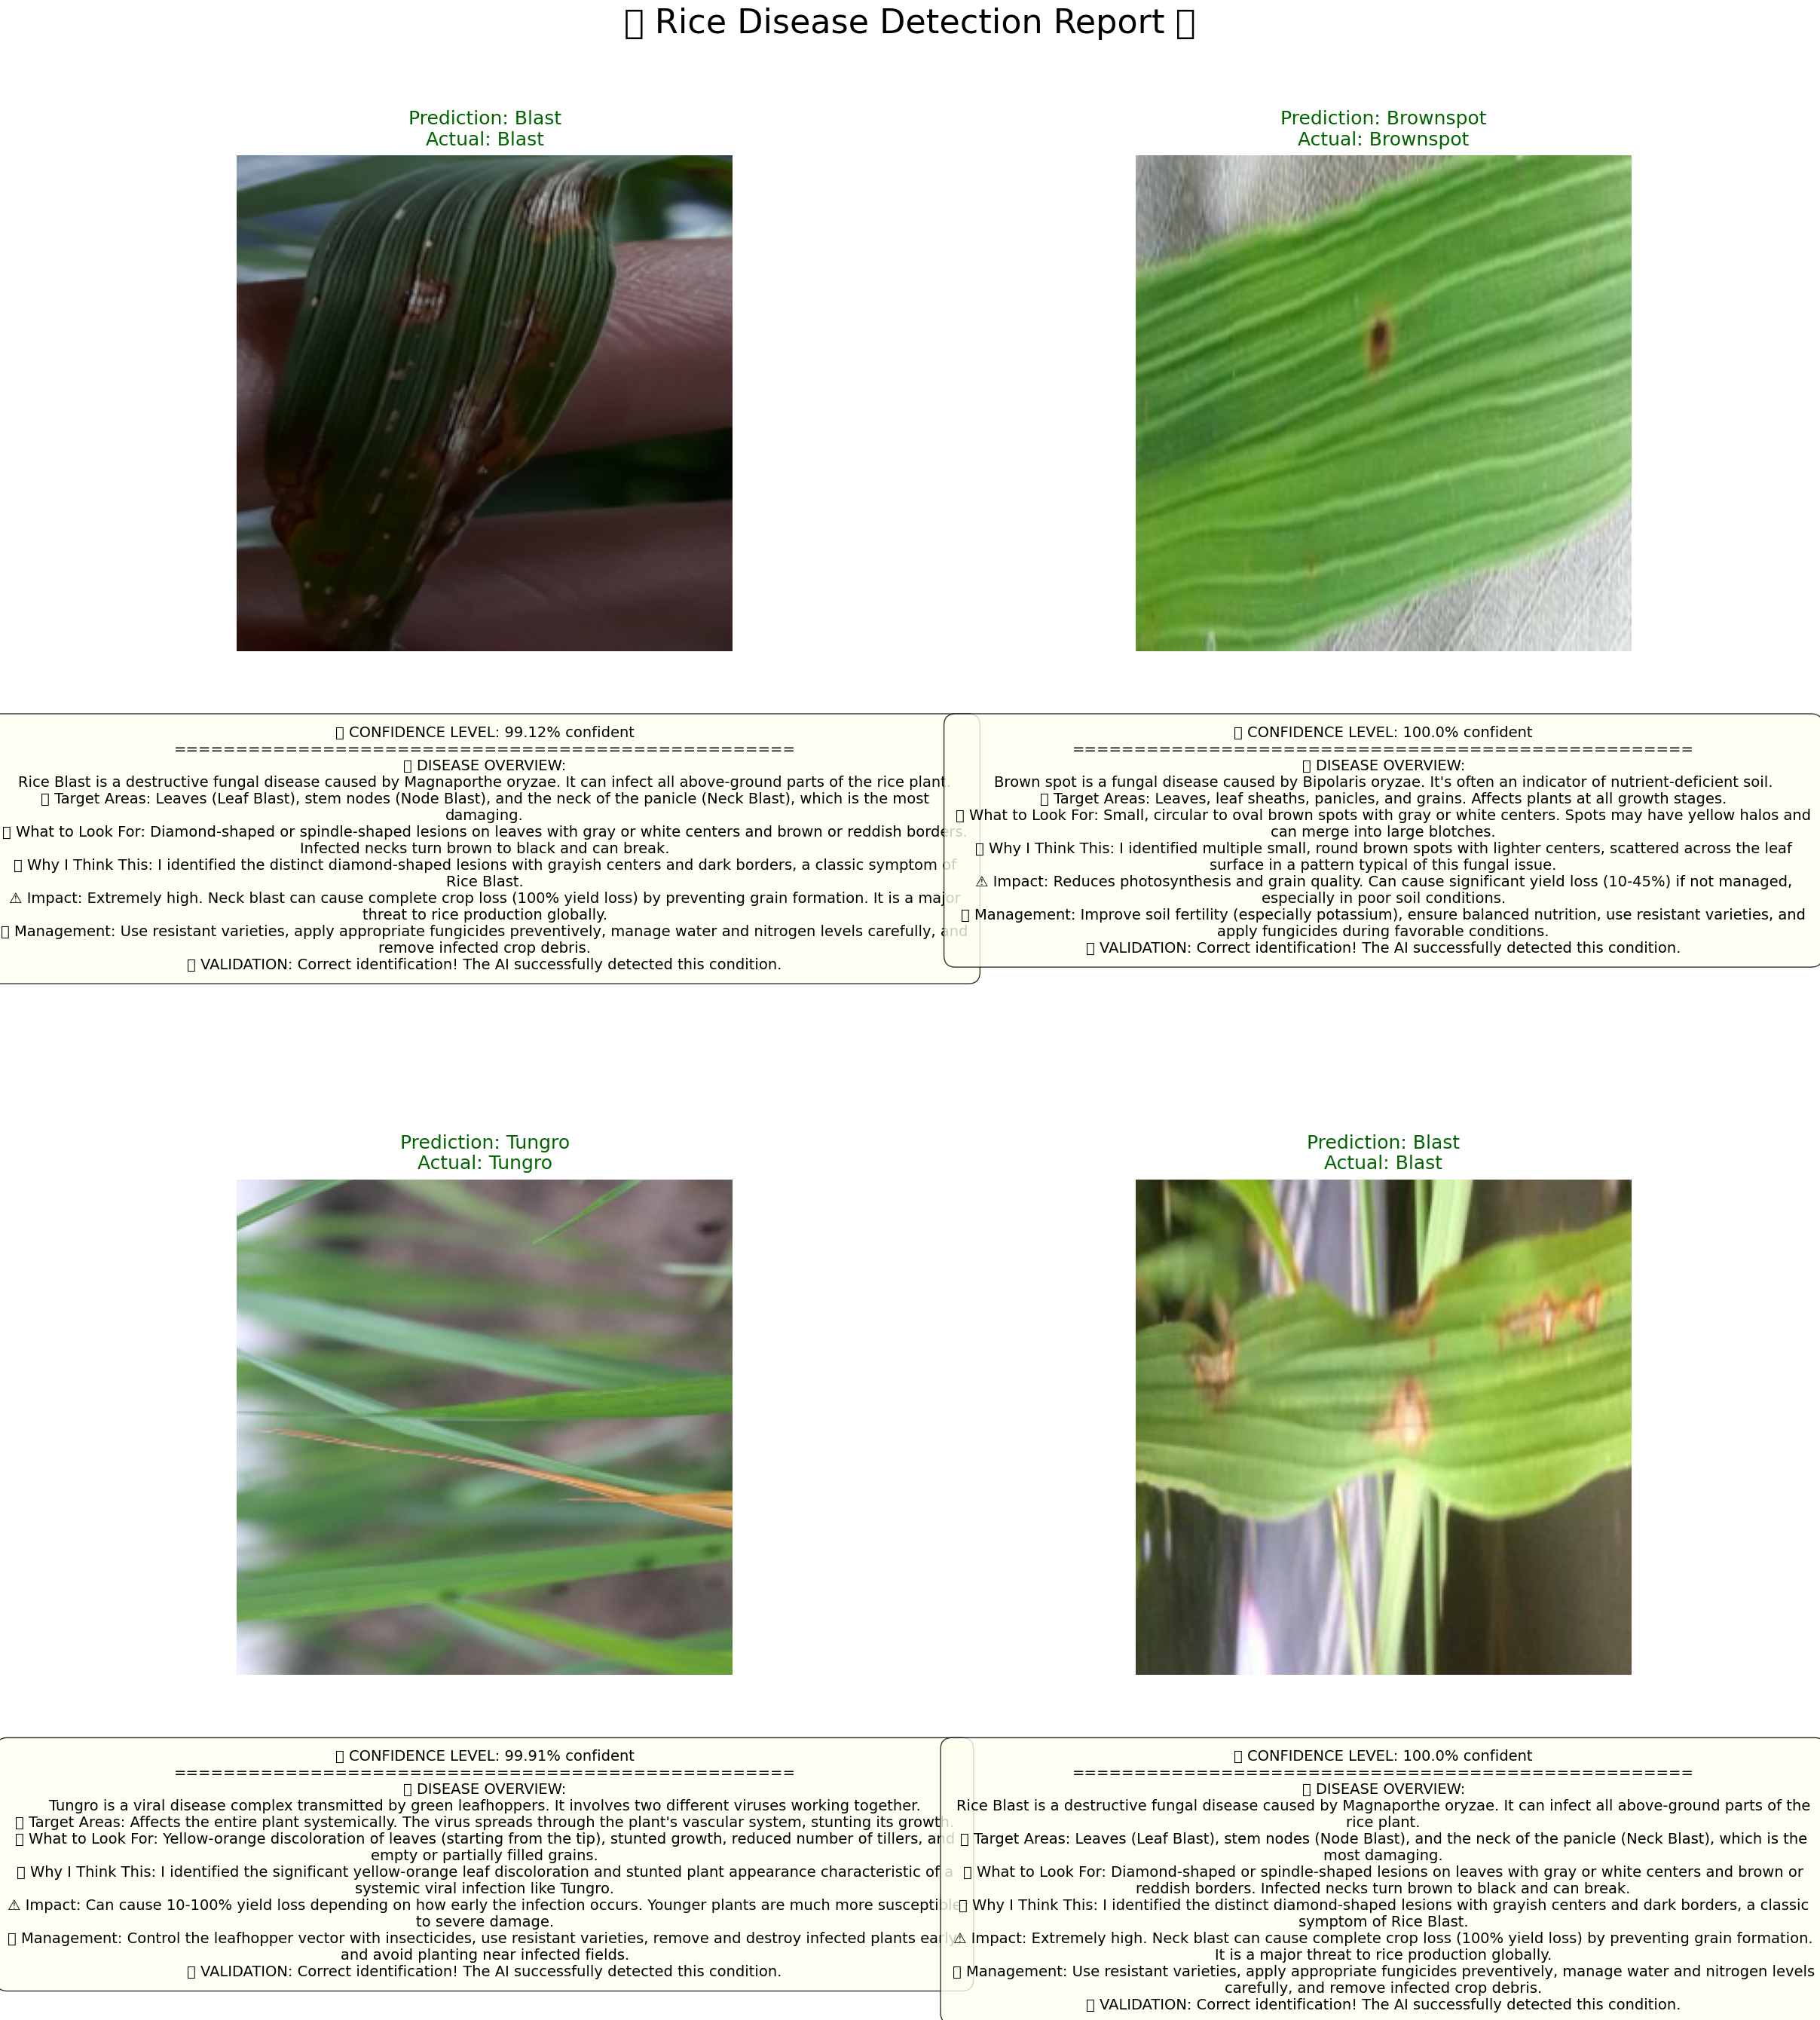

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import textwrap


print("\nSetting up detailed explanations for model predictions...")

def get_eli5_explanation(predicted_class, confidence, actual_class=None):
    """
    Generates detailed, informative explanations for rice disease predictions.
    This version includes 'Blast' and removes 'Leaf Smut'.
    """

    disease_explanations = {
        "Bacterial leaf blight": {
            "what_is_it": "Bacterial leaf blight is caused by the bacterium Xanthomonas oryzae. It's one of the most serious bacterial diseases affecting rice worldwide.",
            "target_areas": "🎯 Target Areas: Leaf edges and tips, leaf sheaths, and sometimes entire leaves. The bacteria enter through water pores and wounds.",
            "visual_symptoms": "👀 What to Look For: Yellow to brown lesions along leaf margins, water-soaked appearance, 'kresek' symptom (wilting of entire tillers), and bacterial ooze in morning dew.",
            "why_detected": "🤖 Why I Think This: I detected characteristic leaf margin yellowing and lesions with a wavy pattern typical of bacterial infection.",
            "severity": "⚠️ Impact: Can cause 20-40% yield loss in severe cases. Most damaging during wet, warm weather conditions.",
            "management": "💡 Management: Use resistant varieties, avoid over-fertilization with nitrogen, ensure proper field drainage, and apply copper-based bactericides if needed."
        },
        "Blast": {
            "what_is_it": "Rice Blast is a destructive fungal disease caused by Magnaporthe oryzae. It can infect all above-ground parts of the rice plant.",
            "target_areas": "🎯 Target Areas: Leaves (Leaf Blast), stem nodes (Node Blast), and the neck of the panicle (Neck Blast), which is the most damaging.",
            "visual_symptoms": "👀 What to Look For: Diamond-shaped or spindle-shaped lesions on leaves with gray or white centers and brown or reddish borders. Infected necks turn brown to black and can break.",
            "why_detected": "🤖 Why I Think This: I identified the distinct diamond-shaped lesions with grayish centers and dark borders, a classic symptom of Rice Blast.",
            "severity": "⚠️ Impact: Extremely high. Neck blast can cause complete crop loss (100% yield loss) by preventing grain formation. It is a major threat to rice production globally.",
            "management": "💡 Management: Use resistant varieties, apply appropriate fungicides preventively, manage water and nitrogen levels carefully, and remove infected crop debris."
        },
        "Brown spot": {
            "what_is_it": "Brown spot is a fungal disease caused by Bipolaris oryzae. It's often an indicator of nutrient-deficient soil.",
            "target_areas": "🎯 Target Areas: Leaves, leaf sheaths, panicles, and grains. Affects plants at all growth stages.",
            "visual_symptoms": "👀 What to Look For: Small, circular to oval brown spots with gray or white centers. Spots may have yellow halos and can merge into large blotches.",
            "why_detected": "🤖 Why I Think This: I identified multiple small, round brown spots with lighter centers, scattered across the leaf surface in a pattern typical of this fungal issue.",
            "severity": "⚠️ Impact: Reduces photosynthesis and grain quality. Can cause significant yield loss (10-45%) if not managed, especially in poor soil conditions.",
            "management": "💡 Management: Improve soil fertility (especially potassium), ensure balanced nutrition, use resistant varieties, and apply fungicides during favorable conditions."
        },
        "Healthy": {
            "what_is_it": "This rice plant shows no signs of disease! Healthy rice has vibrant green leaves, strong stems, and good overall vigor.",
            "target_areas": "🎯 What I See: Uniform green coloration, no lesions or spots, strong upright growth, and healthy leaf structure throughout the plant.",
            "visual_symptoms": "👀 Signs of Health: Bright green leaves without discoloration, clean leaf surfaces, strong stems, and active growth patterns.",
            "why_detected": "🤖 Why I Think This: My analysis shows a uniform green color, the absence of spots or lesions, and a healthy leaf texture, indicating no signs of stress or disease.",
            "importance": "🌟 Why This Matters: Healthy plants achieve maximum yield potential, have better grain quality, and are more resistant to environmental stresses.",
            "maintenance": "💡 Keep It Healthy: Maintain proper nutrition, ensure adequate water management, monitor for early disease signs, and follow integrated pest management practices."
        },
        "Tungro": {
            "what_is_it": "Tungro is a viral disease complex transmitted by green leafhoppers. It involves two different viruses working together.",
            "target_areas": "🎯 Target Areas: Affects the entire plant systemically. The virus spreads through the plant's vascular system, stunting its growth.",
            "visual_symptoms": "👀 What to Look For: Yellow-orange discoloration of leaves (starting from the tip), stunted growth, reduced number of tillers, and empty or partially filled grains.",
            "why_detected": "🤖 Why I Think This: I identified the significant yellow-orange leaf discoloration and stunted plant appearance characteristic of a systemic viral infection like Tungro.",
            "severity": "⚠️ Impact: Can cause 10-100% yield loss depending on how early the infection occurs. Younger plants are much more susceptible to severe damage.",
            "management": "💡 Management: Control the leafhopper vector with insecticides, use resistant varieties, remove and destroy infected plants early, and avoid planting near infected fields."
        }
    }

    class_key = predicted_class

    if "blight" in predicted_class.lower(): class_key = "Bacterial leaf blight"
    elif "blast" in predicted_class.lower(): class_key = "Blast"
    elif "brown" in predicted_class.lower(): class_key = "Brown spot"
    elif "healthy" in predicted_class.lower(): class_key = "Healthy"
    elif "tungro" in predicted_class.lower(): class_key = "Tungro"

    explanation = disease_explanations.get(class_key, {})


    text_parts = [
        f"🌾 DIAGNOSIS: {predicted_class}",
        f"🎯 CONFIDENCE LEVEL: {confidence}% confident",
        f"{'='*50}"
    ]

    if "what_is_it" in explanation: text_parts.append(f"📋 DISEASE OVERVIEW:\n{explanation['what_is_it']}")
    if "target_areas" in explanation: text_parts.append(explanation['target_areas'])
    if "visual_symptoms" in explanation: text_parts.append(explanation['visual_symptoms'])
    if "why_detected" in explanation: text_parts.append(explanation['why_detected'])

    if predicted_class.lower() != "healthy":
        if "severity" in explanation: text_parts.append(explanation['severity'])
        if "management" in explanation: text_parts.append(explanation['management'])
    else:
        if "importance" in explanation: text_parts.append(explanation['importance'])
        if "maintenance" in explanation: text_parts.append(explanation['maintenance'])

    if actual_class:
        if predicted_class == actual_class:
            text_parts.append("✅ VALIDATION: Correct identification! The AI successfully detected this condition.")
        else:
            text_parts.append(f"❌ CORRECTION: AI predicted {predicted_class}, but actual condition is {actual_class}. This helps improve the model's learning.")

    return "\n\n".join(text_parts)

def create_confidence_meter(confidence):
    """Creates a simple visual confidence meter"""
    filled_bars = int(confidence / 10)
    empty_bars = 10 - filled_bars
    meter = "█" * filled_bars + "░" * empty_bars
    return f"Confidence: [{meter}] {confidence}%"


print("Generating a clear, spacious report with embedded explanations...")

fig, axes = plt.subplots(2, 2, figsize=(24, 28))
fig.suptitle("🌾 Rice Disease Detection Report 🌾", fontsize=32, y=0.96)

axes = axes.flatten() 

for images, labels in test_ds.take(1):
  
    for i in range(4):
        if i >= len(images): 
            axes[i].axis('off')
            continue

        ax = axes[i]
        img_tensor = images[i]
        img_array = tf.expand_dims(img_tensor, 0)

        preds = model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(preds[0])
        confidence = round(100 * np.max(preds[0]), 2)

        actual_class = class_names[labels[i]]
        predicted_class = class_names[predicted_class_index]

      
        ax.imshow(img_tensor.numpy().astype(np.uint8))

        
        confidence_meter = create_confidence_meter(confidence)
        short_title = f"Prediction: {predicted_class}\nActual: {actual_class}"
        title_color = 'darkgreen' if predicted_class == actual_class else 'darkred'
        ax.set_title(short_title, color=title_color, fontsize=18, pad=10)
        ax.axis("off")

        
        eli5_explanation = get_eli5_explanation(predicted_class, confidence, actual_class)

        
        plot_text = "\n".join(eli5_explanation.split('\n\n')[1:])

        ax.text(0.5, -0.15, plot_text,
                transform=ax.transAxes,
                fontsize=14,
                verticalalignment='top',
                horizontalalignment='center',
                wrap=True,
                bbox=dict(boxstyle='round,pad=0.8', fc='ivory', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(hspace=0.6) 
plt.show()




🔬 PREDICTING ON A SINGLE IMAGE

Processing image: /kaggle/input/rice-disease-detection/Rice Leaf Disease Images/Healthy/HEALTHY_IMAGE1.jpg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


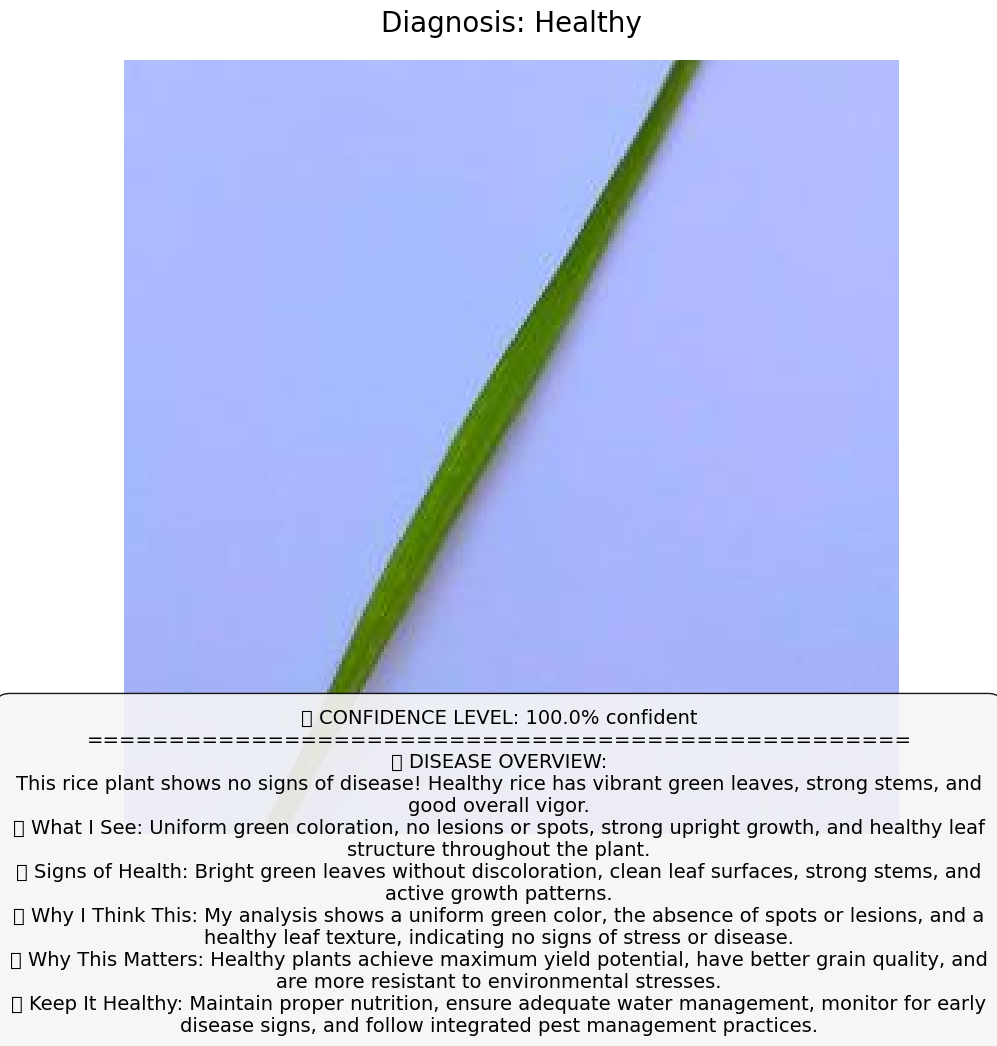

In [10]:


def predict_and_explain_single_image(image_path, model, class_names):
    """
    Loads an image from a file path, gets a prediction and explanation
    from the model, and displays the result in a clear format.
    """
    print(f"\nProcessing image: {image_path}")


    IMG_SIZE = 256

    try:
        
        img = tf.keras.utils.load_img(
            image_path, target_size=(IMG_SIZE, IMG_SIZE)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        
        predictions = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(predictions[0])
        confidence = 100 * np.max(predictions[0])
        predicted_class = class_names[predicted_index]

        
        explanation = get_eli5_explanation(predicted_class, round(confidence, 2))

        
        plt.figure(figsize=(10, 12))
        plt.imshow(img)
        plt.title(f"Diagnosis: {predicted_class}", fontsize=20, pad=20)
        plt.axis("off")

        plot_text = "\n".join(explanation.split('\n\n')[1:])

        plt.figtext(0.5, 0.01, plot_text,
                    ha="center",
                    fontsize=14,
                    wrap=True,
                    bbox=dict(boxstyle='round,pad=0.8', fc='whitesmoke', alpha=0.9))

        plt.show()

    except FileNotFoundError:
        print(f"❌ ERROR: The file was not found at '{image_path}'. Please check the path and try again.")
    except Exception as e:
        print(f"An error occurred: {e}")



print("\n" + "="*80)
print("🔬 PREDICTING ON A SINGLE IMAGE")
print("="*80)


my_image_path = '/kaggle/input/rice-disease-detection/Rice Leaf Disease Images/Healthy/HEALTHY_IMAGE1.jpg'



if 'path/to/your/image.jpg' in my_image_path:
    print("❗ Please update the 'my_image_path' variable with the actual path to your image.")
else:
   
    predict_and_explain_single_image(my_image_path, model, class_names)